# Minimal integral measures

One approach to finding controller parameters is to minimise some error measure with respect to the parameters. We will simulate a first order plus dead time system under PI control. The block diagram here is for simple feedback:

![](../../assets/simple_feedback.png)

In [1]:
import numpy
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
from tbcontrol import blocksim
%matplotlib inline

In [2]:
# This is the 1,1 element of a Wood and Berry column (see eq 16-12)
K = 12.8
tau = 16.7
theta = 1

In [3]:
ts = numpy.linspace(0, 2*tau, 500)

In [4]:
ysp = 1

In [5]:
Kc = 1
tau_i = 1

In [6]:
def response(Kc, tau_i):
    Gp = blocksim.LTI('G', 'u', 'y', [K], [tau, 1], theta)
    Gc = blocksim.PI('Gc', 'e', 'u', Kc, tau_i)

    blocks = [Gp, Gc]
    inputs = {'ysp': lambda t: ysp}
    sums = {'e': ('+ysp', '-y')}

    diagram = blocksim.Diagram(blocks, sums, inputs)
    
    return numpy.array(diagram.simulate(ts)['y'])

What does the setpoint response look like?

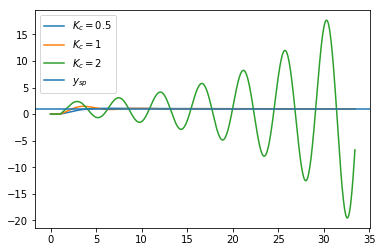

In [7]:
for Kc in [0.5, 1, 2]:
    plt.plot(ts, response(Kc, 10), label='$K_c={}$'.format(Kc))
plt.axhline(ysp, label='$y_{sp}$')
plt.legend()

These are the error measures in the book (eq 11-35 to 11-37). Note that the syntax `f(*parameters)` with `parameters=(1, 2)` is equivalent to `f(1, 2)`. 

In [8]:
def iae(parameters):
    return scipy.integrate.trapz(numpy.abs(response(*parameters) - ysp), ts)

In [9]:
def ise(parameters):
    return scipy.integrate.trapz((response(*parameters) - ysp)**2, ts)

In [10]:
def itae(parameters):
    return scipy.integrate.trapz(numpy.abs(response(*parameters) - ysp)*ts, ts)

In [11]:
errfuns = [iae, ise, itae]

Now we can find the optimal parameters for the various error measures.

IAE 0.6639499654277579 16.700104675285132
ISE 0.8519796593454986 25.498163370798167
ITAE 0.5856442797588636 16.69999502290863
CPU times: user 1min 26s, sys: 3 s, total: 1min 29s
Wall time: 1min 35s


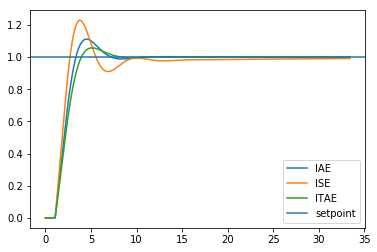

In [12]:
%%time
optimal_parameters = {}
for error in errfuns:
    name = error.__name__.upper()
    optimal_parameters[name] = scipy.optimize.minimize(error, [1, 10]).x
    print(name, *optimal_parameters[name])
    plt.plot(ts, response(*optimal_parameters[name]), label=name)
plt.axhline(1, label='setpoint')
plt.legend(loc='best')

We could also have used table 11.3, which is automated by a function in `tbcontrol` (see the [ITAE parameters for FOPDT system](ITAE%20parameters%20for%20FOPDT%20system.ipynb) notebook for more information on this function)

In [14]:
from tbcontrol.fopdtitae import parameters

In [15]:
Kc, tau_i = parameters(K, tau, theta, "Set point", "PI")

print(Kc, tau_i)

0.6035259299979403 16.370626907724816


These values correspond approximately with those found through direct minimisation.

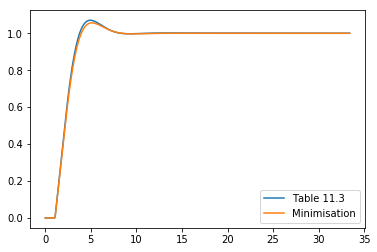

In [16]:
plt.plot(ts, response(Kc, tau_i), label='Table 11.3')
plt.plot(ts, response(*optimal_parameters['ITAE']), label='Minimisation')
plt.legend()

In [17]:
itae([Kc, tau_i])

4.025429557262326

In [18]:
itae(optimal_parameters['ITAE'])

3.644873223762508

Note that the error we obtained via direct minimisation was lower than the one obtained via the table, as they have fitted a curve through the results.